In [1]:
import gifba
from scipy.integrate import solve_ivp
import numpy as np
import cobra as cb
import pandas as pd
from IPython.display import clear_output
import copy

# def params
diff_coef = 0.1  # Diffusion coefficient
models, media = gifba.utils.load_simple_models("2a")


community = gifba.gifbaObject(models, media, "equal")
_, _ = community.run_gifba(iters=1, method="pfba", early_stop=True, v=False)
clear_output()

# equal rel_abund
rel_abund = community.rel_abund.copy()

# media from gifba
substrate_0 = community.env_fluxes.loc[0, :].to_dict()
substrate_0

# kinetic params
V_MAX_ALL = 1000  # Maximum uptake rate for all substrates
K_M_ALL = 0.1  # Michaelis-Menten constant for all substrates
vmax_vals = pd.DataFrame(np.full((len(models), len(substrate_0.keys())), V_MAX_ALL),
                              columns=list(substrate_0.keys()),
                              index=[str(mdl_idx) for mdl_idx in range(len(models))])
km_vals = pd.DataFrame(np.full((len(models), len(substrate_0.keys())), K_M_ALL),
                              columns=list(substrate_0.keys()),
                              index=[str(mdl_idx) for mdl_idx in range(len(models))])


    


In [ ]:

def dsdt(t, S, models, vmax, km, D, media_keys, media_values, last_t):
    # Initialize net change with dilution/diffusion: D * (S_in - S_now)
    # S and net_change are indexed by media_keys
    # ds = D * (media_values - S) 
    
    #get dt for step
    dt = t - last_t[0]
    if dt <= 0: dt = 1e-3
    last_t[0] = t
    # dt=0.1
    print(t, dt)
    

    # Create a mapping for quick lookup: {metabolite_id: current_concentration}
    conc_map = dict(zip(media_keys, S))
    
    for mdl_idx, model in enumerate(models):
        # 1. Update lower bounds based on Michaelis-Menten kinetics
        for ex_id in media_keys:
            if ex_id in model.reactions and "bio" not in ex_id:
                v_max = vmax.loc[str(mdl_idx), ex_id]
                k_m = km.loc[str(mdl_idx), ex_id]
                c = conc_map[ex_id]
                if c < 1e-6:
                    c = 0.0  # Avoid very small concentrations

                # Michaelis-Menten uptake limit (negative for COBRA convention)
                uptake_limit = (v_max * c) / (k_m + c)
                max_uptake_available = c / (rel_abund[mdl_idx] * dt)  # per second basis
                model.reactions.get_by_id(ex_id).lower_bound = -uptake_limit
                # print(mdl_idx, ex_id, uptake_limit)

        # 2. Run FBA
        solution = model.optimize()
        # print(f"Model {mdl_idx} status: {solution.status} solution: {solution.objective_value}")

        # 3. Add fluxes to the net change (weighted by relative abundance)
        if solution.status == 'optimal':
            for i, ex_id in enumerate(media_keys):
                # We assume relative abundance is constant (X_clamp)
                flux = solution.fluxes.get(ex_id, 0) / 3600 # Convert to per second
                ds[i] += flux * dt * rel_abund[mdl_idx]
        else:
            # If a model is infeasible at these concentrations, it contributes 0 flux
            pass
            
    return ds

# Preparing cleaner inputs for solve_ivp
m_keys = list(substrate_0.keys()) # Metabolite keys
m_vals = np.array([substrate_0[k] for k in m_keys]) # Initial concentrations
y0 = m_vals.copy()
last_t = [0]

sol = solve_ivp(
    dsdt,
    t_span=(0, 100),
    y0=y0,
    args=(copy.deepcopy(models), vmax_vals, km_vals, diff_coef, m_keys, m_vals, last_t),
    method='BDF' # BDF is usually better for stiff biological ODEs
)

In [40]:
dt = 1/2000
t_hr = np.arange(0, 2, dt)  # Simulate for 48 hours with 1-second intervals
S = np.zeros((len(t_hr), len(substrate_0)))  # Concentration matrix
S[0, :] = np.array(list(substrate_0.values()))

for t_idx, t in enumerate(t_hr):
    c = S[t_idx, :].copy()

    # Apply diffusion/dilution
    ds = diff_coef * (np.array(list(substrate_0.values())) - c) * dt

    # Update lower bounds based on Michaelis-Menten kinetics
    for mdl_idx, model in enumerate(models):
        for ex_id in substrate_0.keys():

            if ex_id in model.reactions and "bio" not in ex_id:
                v_max = vmax_vals.loc[str(mdl_idx), ex_id]
                k_m = km_vals.loc[str(mdl_idx), ex_id]
                conc = c[list(substrate_0.keys()).index(ex_id)]
                if conc < 1e-6:
                    conc = 0.0  # Avoid very small concentrations

                # Michaelis-Menten uptake limit (negative for COBRA convention)
                uptake_limit = (v_max * conc) / (k_m + conc)
                max_uptake_available = conc / (rel_abund[mdl_idx] * dt)  # per hr basis
                model.reactions.get_by_id(ex_id).lower_bound = -uptake_limit
        
        # Run FBA for each model and update concentrations
        solution = model.optimize()
        if solution.status == 'optimal':
            for i, ex_id in enumerate(substrate_0.keys()):
                flux = solution.fluxes.get(ex_id, 0)
                ds[i] += flux * dt * rel_abund[mdl_idx]
    
    if t_idx % 1000 == 0:
        print(f"Time: {t:.2f} hr")
    # set next time point concentration
    if t_idx + 1 < len(t_hr):
        S[t_idx + 1, :] = c + ds
    
    


Time: 0.00 hr
Time: 0.50 hr
Time: 1.00 hr
Time: 1.50 hr


In [39]:
# print(sol.y)
print(S)

[[ 1.00000000e+01  0.00000000e+00  0.00000000e+00]
 [ 9.00990099e+00  4.95049505e-01  4.95049505e-01]
 [ 8.02097707e+00  9.89511466e-01  9.89511466e-01]
 ...
 [-2.44816354e-03  5.00122408e+00  5.00122408e+00]
 [-1.44791873e-03  5.00072396e+00  5.00072396e+00]
 [-4.47773934e-04  5.00022389e+00  5.00022389e+00]]


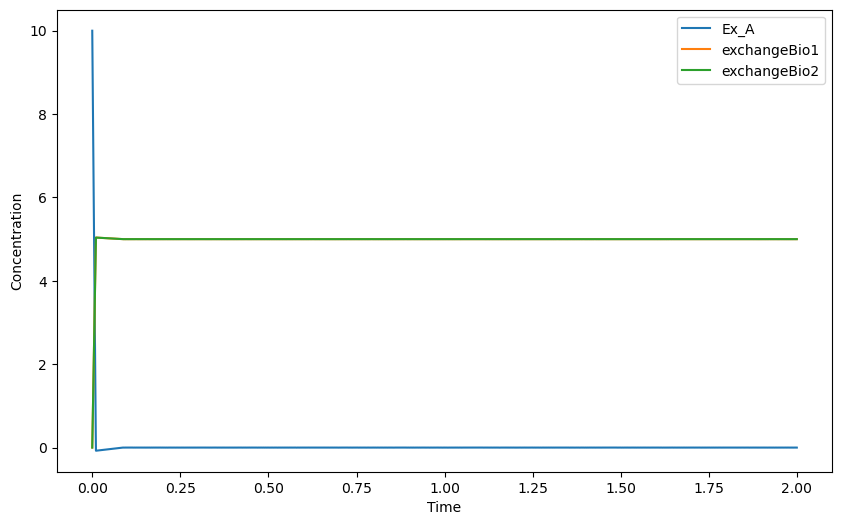

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, met_id in enumerate(["Ex_A", "exchangeBio1", "exchangeBio2"]):
    plt.plot(t_hr, S[:, list(substrate_0.keys()).index(met_id)], label=met_id)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()

In [1]:
import gifba
from scipy.integrate import solve_ivp
import numpy as np
import cobra as cb
import pandas as pd
from IPython.display import clear_output
import copy
from tqdm import tqdm

# def params
diff_coef = 0.1  # Diffusion coefficient
# Load Models
m1 = cb.io.load_matlab_model('../Examples/AGORA2_Models/Bifidobacterium_longum_infantis_ATCC_15697.mat')
m2 = cb.io.load_matlab_model('../Examples/AGORA2_Models/Eubacterium_hallii_DSM_3353.mat')

models = [m1, m2]
# Define Media
# AGORA Format
media = {
	'EX_o2(e)': 0, #aerobic/anaerobic
	'EX_h2o(e)': -1000,
	'EX_pi(e)': -1000,
	'EX_fe2(e)': -1000,
	'EX_fe3(e)': -1000,
	'EX_zn2(e)': -1000,
	'EX_so4(e)': -1000,
	'EX_cu2(e)': -1000,
	'EX_k(e)': -1000,
	'EX_mg2(e)': -1000,
	'EX_mn2(e)': -1000,
	'EX_cd2(e)': -1000,
	'EX_cl(e)': -1000,
	'EX_ca2(e)': -1000,
	'EX_cobalt2(e)': -1000,
	'EX_glc_D(e)': -10,
	'EX_nh4(e)': -20,

	'EX_ribflv(e)': -1000,
	'EX_pnto_R(e)': -1000,
	'EX_nac(e)': -1000,
	'EX_his_L(e)': -1000,
	'EX_asn_L(e)': -1000,
	'EX_glycys(e)': -1000,

	'EX_lys_L(e)': -1000,
	'EX_ala_L(e)': -1000,
	'EX_met_L(e)': -1000,
	'EX_leu_L(e)': -1000,
	'EX_hxan(e)': -1000,    
	'EX_ser_L(e)': -1,
}


community = gifba.gifbaObject(models, media, "equal")
_, _ = community.run_gifba(iters=1, method="pfba", early_stop=True, v=False)
clear_output()

# equal rel_abund
rel_abund = community.rel_abund.copy()

# media from gifba
substrate_0 = community.env_fluxes.loc[0, :].to_dict()
substrate_0

# kinetic params
V_MAX_ALL = 1000  # Maximum uptake rate for all substrates
K_M_ALL = 0.1  # Michaelis-Menten constant for all substrates
vmax_vals = pd.DataFrame(np.full((len(models), len(substrate_0.keys())), V_MAX_ALL),
                              columns=list(substrate_0.keys()),
                              index=[str(mdl_idx) for mdl_idx in range(len(models))])
km_vals = pd.DataFrame(np.full((len(models), len(substrate_0.keys())), K_M_ALL),
                              columns=list(substrate_0.keys()),
                              index=[str(mdl_idx) for mdl_idx in range(len(models))])


    


In [ ]:
dt = 1/1000
t_hr = np.arange(0, 6, dt)  # Simulate for 6hrs intervals
S = np.zeros((len(t_hr), len(substrate_0)))  # Concentration matrix
S[0, :] = np.array(list(substrate_0.values()))

for t_idx, t in tqdm(enumerate(t_hr), total=len(t_hr), desc="Simulating"):
    c = S[t_idx, :].copy()

    # Apply diffusion/dilution
    ds = diff_coef * (np.array(list(substrate_0.values())) - c) * dt

    # Update lower bounds based on Michaelis-Menten kinetics
    for mdl_idx, model in enumerate(models):
        for ex_id in substrate_0.keys():

            if ex_id in model.reactions and "bio" not in ex_id:
                v_max = vmax_vals.loc[str(mdl_idx), ex_id]
                k_m = km_vals.loc[str(mdl_idx), ex_id]
                conc = c[list(substrate_0.keys()).index(ex_id)]
                if conc < 1e-6:
                    conc = 0.0  # Avoid very small concentrations

                # Michaelis-Menten uptake limit (negative for COBRA convention)
                uptake_limit = (v_max * conc) / (k_m + conc)
                # max_uptake_available = conc / (rel_abund[mdl_idx] * dt)  # per hr basis
                model.reactions.get_by_id(ex_id).lower_bound = -uptake_limit
        
        # Run FBA for each model and update concentrations
        solution = model.optimize()
        if solution.status == 'optimal':
            for i, ex_id in enumerate(substrate_0.keys()):
                flux = solution.fluxes.get(ex_id, 0)
                ds[i] += flux * dt * rel_abund[mdl_idx]
    
    # if t_idx % 1000 == 0:
    #     print(f"Time: {t:.2f} hr")
    # set next time point concentration
    if t_idx + 1 < len(t_hr):
        S[t_idx + 1, :] = c + ds
    
    


Simulating: 100%|██████████| 6000/6000 [03:41<00:00, 27.10it/s]


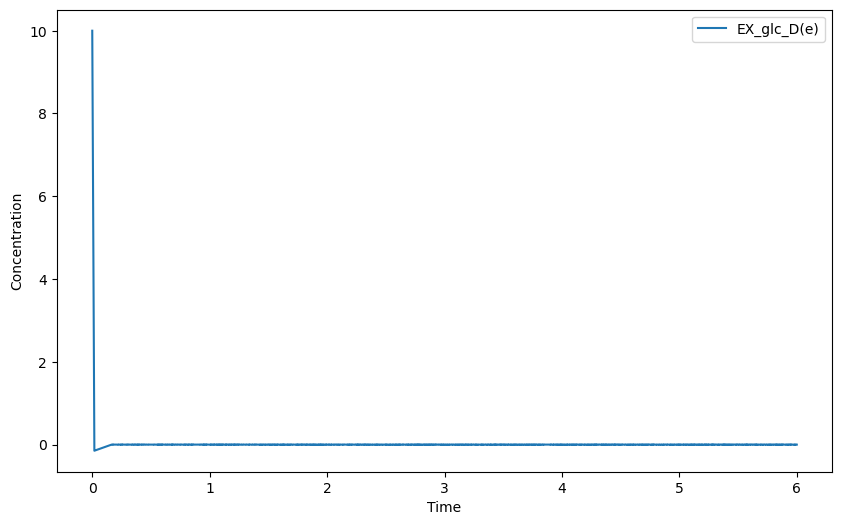

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, met_id in enumerate(["EX_glc_D(e)"]):
    plt.plot(t_hr, S[:, list(substrate_0.keys()).index(met_id)], label=met_id)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()

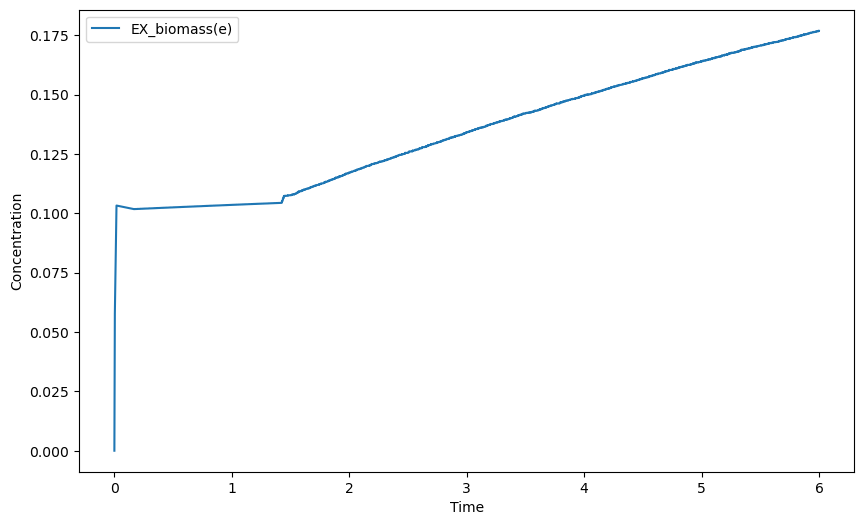

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, met_id in enumerate(["EX_biomass(e)"]):
    plt.plot(t_hr, S[:, list(substrate_0.keys()).index(met_id)], label=met_id)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()

In [13]:
# run fba at the end to see final fluxes
c = S[-1, :].copy()
ds = diff_coef * (np.array(list(substrate_0.values())) - c) 

S_fin = c + ds
for mdl_idx, model in enumerate(models):
    for ex_id in substrate_0.keys():
        

        if ex_id in model.reactions and "bio" not in ex_id:
            v_max = vmax_vals.loc[str(mdl_idx), ex_id]
            k_m = km_vals.loc[str(mdl_idx), ex_id]
            conc = S_fin[list(substrate_0.keys()).index(ex_id)]
            if conc < 1e-6:
                conc = 0.0  # Avoid very small concentrations

            # Michaelis-Menten uptake limit (negative for COBRA convention)
            uptake_limit = (v_max * conc) / (k_m + conc)
            model.reactions.get_by_id(ex_id).lower_bound = -uptake_limit
    
    # Run FBA for each model and update concentrations
    solution = model.optimize()
    print(f"Model {mdl_idx} final status: {solution.status} solution: {solution.objective_value}")
    # if solution.status == 'optimal':
    #     for i, ex_id in enumerate(substrate_0.keys()):
    #         flux = solution.fluxes.get(ex_id, 0)
    print(model.summary())

Model 0 final status: optimal solution: 6.521199545119649
Objective
1.0 biomass525 = 6.521199545119649

Uptake
------
     Metabolite       Reaction    Flux  C-Number C-Flux
       asn_L[e]    EX_asn_L(e)    1.53         4  0.18%
         ca2[e]      EX_ca2(e) 0.05093         0  0.00%
          cl[e]       EX_cl(e) 0.05093         0  0.00%
     cobalt2[e]  EX_cobalt2(e) 0.05093         0  0.00%
         cu2[e]      EX_cu2(e) 0.05093         0  0.00%
         fe2[e]      EX_fe2(e) 0.05093         0  0.00%
         fe3[e]      EX_fe3(e) 0.05093         0  0.00%
         for[e]      EX_for(e)   2.829         1  0.08%
       glc_D[e]    EX_glc_D(e)   552.6         6 98.34%
      glycys[e]   EX_glycys(e)   1.707         5  0.25%
       his_L[e]    EX_his_L(e)   0.604         6  0.11%
        hxan[e]     EX_hxan(e)   2.881         5  0.43%
           k[e]        EX_k(e) 0.05093         0  0.00%
       leu_L[e]    EX_leu_L(e)   2.861         6  0.51%
         mg2[e]      EX_mg2(e) 0.05093    

0.1


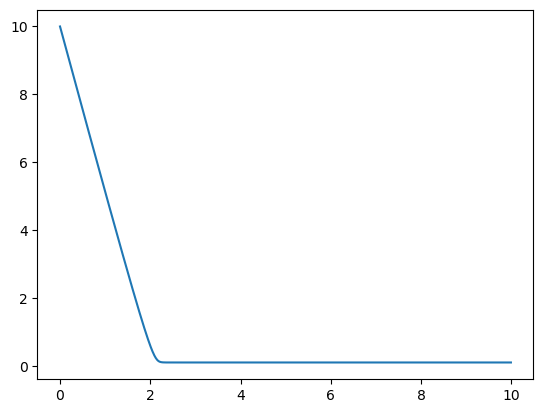

In [7]:
import numpy as np

t = []
dt = 0.01
km = 0.1
vmax = 10
M = 5
xs = [10]

for i in range(1000):
    t.append(t[-1]+dt if i>0 else 0)
    dsubstrate = M - vmax * xs[-1] / (km + xs[-1])
    xs.append(xs[-1]+dsubstrate*dt)


import matplotlib.pyplot as plt
plt.plot(t, xs[:-1])
print(xs[-1])

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gifba
from IPython.display import clear_output


V = 1
gt = 1

vmax = 10
km=0.1
x0 = {"Ex_A": 0}
    #   "Ex_B": 10}
dt=0.01
# alpha=

iters = 25
models, media = gifba.utils.load_simple_models("1a")
community = gifba.gifbaObject(models, media, "equal")
_, _ = community.run_gifba(iters=1, method="pfba", early_stop=True, v=False)
clear_output()

#time
t = np.arange(0, iters)

# concentrations
x = np.zeros((iters, len(community.org_exs)))
x_df = pd.DataFrame(x, 
                    columns=community.org_exs, 
                    index=t)
for met, conc in x0.items():
    x_df.loc[0, met] = conc

# fluxes
fluxes = np.zeros((iters * community.size, len(community.org_rxns)))
its_col = np.repeat(t, community.size)
mdl_idx_col = np.tile(range(community.size), iters)
fluxes_df = pd.DataFrame(fluxes, columns=community.org_rxns,
                         index=[its_col, mdl_idx_col])
fluxes_df.index.names = ["Iters", "Model"]


# media 
M = pd.Series(np.zeros(len(community.org_exs)), index=community.org_exs)
for met, flux in media.items():
    M[met] = np.abs(flux)
M["Ex_A"] = 5

for it in range(iters):
    print(f"Iteration {it}:")
    for mdl_idx in range(community.size):
        print(f"  Model {mdl_idx}:")
        # reset bounds
        for ex in community.models[mdl_idx].exchanges:
            community.models[mdl_idx].exchanges.get_by_id(ex.id).lower_bound = 0
            community.models[mdl_idx].exchanges.get_by_id(ex.id).upper_bound = 1000

            # find v bounds with michaelis menten
            conc = x_df.loc[it, ex.id]
            print(ex.id, ":  vmax", vmax, "conc", conc, "km", km)
            v_lb = vmax * conc / (km+conc)
            print(v_lb)
            community.models[mdl_idx].exchanges.get_by_id(ex.id).lower_bound = -v_lb

        # optimize
        sol = community.models[mdl_idx].optimize()

        print(f"    Objective Value: {sol.objective_value}")
        # store fluxes
        if sol.status == "optimal":
            fluxes_df.loc[(it, mdl_idx), list(sol.fluxes.index)] = sol.fluxes.values

    # update concentrations
    for met, x in x_df.loc[it].items():
        # print(met)
        # calc dx for exchanges
        # dx = dt*(M * alpha + gt*(E@rel_abund) * (1-alpha))
        exs = fluxes_df.loc[(it, slice(None)), met].to_numpy() @ community.rel_abund.flatten() #sum  exchange per org * rel_abund
        # dx = dt * (M[met] * alpha + (1-alpha)*gt*exs)
        dx = dt * (M[met]  + gt*exs)
        print(met, dx, x+dx)

        # update x_(t+1) based on x(t+1) = x(t) + dx
        x_df.loc[it+1, met] = x + dx
    print()

x_df.index = x_df.index * dt

        
            


Iteration 0:
  Model 0:
Ex_A :  vmax 10 conc 0.0 km 0.1
0.0
exchangeBio1 :  vmax 10 conc 0.0 km 0.1
0.0
    Objective Value: 0.0
exchangeBio1 0.0 0.0
Ex_A 0.05 0.05

Iteration 1:
  Model 0:
Ex_A :  vmax 10 conc 0.05 km 0.1
3.333333333333333
exchangeBio1 :  vmax 10 conc 0.0 km 0.1
0.0
    Objective Value: 3.333333333333333
exchangeBio1 0.03333333333333333 0.03333333333333333
Ex_A 0.01666666666666667 0.06666666666666668

Iteration 2:
  Model 0:
Ex_A :  vmax 10 conc 0.06666666666666668 km 0.1
4.0
exchangeBio1 :  vmax 10 conc 0.03333333333333333 km 0.1
2.5
    Objective Value: 4.0
exchangeBio1 0.04 0.07333333333333333
Ex_A 0.01 0.07666666666666667

Iteration 3:
  Model 0:
Ex_A :  vmax 10 conc 0.07666666666666667 km 0.1
4.339622641509433
exchangeBio1 :  vmax 10 conc 0.07333333333333333 km 0.1
4.230769230769231
    Objective Value: 4.339622641509433
exchangeBio1 0.04339622641509434 0.11672955974842766
Ex_A 0.006603773584905666 0.08327044025157235

Iteration 4:
  Model 0:
Ex_A :  vmax 10 conc

In [94]:
x_df

,Ex_A,exchangeBio1
0.00,0.000000,0.000000
0.01,0.050000,0.000000
0.02,0.066667,0.033333
0.03,0.076667,0.073333
0.04,0.083270,0.116730
...,...,...
0.96,0.100000,4.700000
0.97,0.100000,4.750000
0.98,0.100000,4.800000
0.99,0.100000,4.850000


4.998814149611462

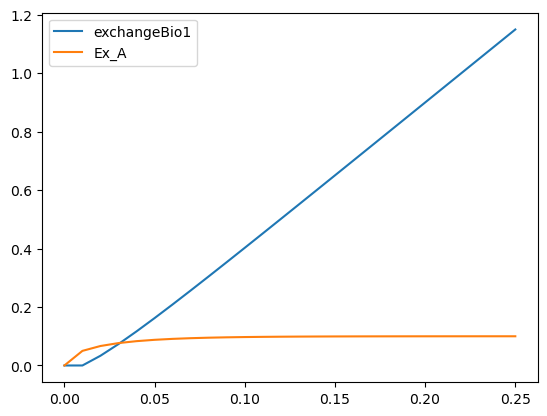

In [36]:
for met in x_df.columns:
    plt.plot(x_df.index, x_df[met], label=met)



plt.legend()
fluxes_df.iloc[-1]["exchangeBio1"]

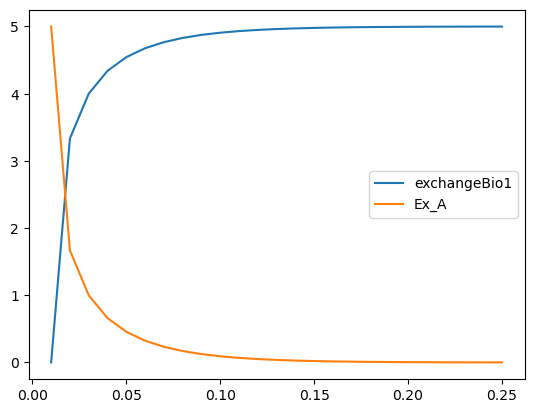

In [39]:
for met in x_df.columns:
    plt.plot(x_df.index, x_df[met].diff() /dt, label=met)

plt.legend()

# add alpha (alpha = 0)

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gifba
from IPython.display import clear_output


V = 1
gt = 1

vmax = 10
km=0.1
x0 = {"Ex_A": 0}
    #   "Ex_B": 10}
dt=0.01
alpha= 0

iters = 25
models, media = gifba.utils.load_simple_models("1a")
community = gifba.gifbaObject(models, media, "equal")
_, _ = community.run_gifba(iters=1, method="pfba", early_stop=True, v=False)
clear_output()

#time
t = np.arange(0, iters)

# concentrations
x = np.zeros((iters, len(community.org_exs)))
x_df = pd.DataFrame(x, 
                    columns=community.org_exs, 
                    index=t)
for met, conc in x0.items():
    x_df.loc[0, met] = conc

# fluxes
fluxes = np.zeros((iters * community.size, len(community.org_rxns)))
its_col = np.repeat(t, community.size)
mdl_idx_col = np.tile(range(community.size), iters)
fluxes_df = pd.DataFrame(fluxes, columns=community.org_rxns,
                         index=[its_col, mdl_idx_col])
fluxes_df.index.names = ["Iters", "Model"]


# media 
M = pd.Series(np.zeros(len(community.org_exs)), index=community.org_exs)
for met, flux in media.items():
    M[met] = np.abs(flux)
M["Ex_A"] = 5

for it in range(iters):
    print(f"Iteration {it}:")
    for mdl_idx in range(community.size):
        print(f"  Model {mdl_idx}:")
        # reset bounds
        for ex in community.models[mdl_idx].exchanges:
            community.models[mdl_idx].exchanges.get_by_id(ex.id).lower_bound = 0
            community.models[mdl_idx].exchanges.get_by_id(ex.id).upper_bound = 1000

            # find v bounds with michaelis menten
            conc = x_df.loc[it, ex.id]
            print(ex.id, ":  vmax", vmax, "conc", conc, "km", km)
            v_lb = vmax * conc / (km+conc)
            print(v_lb)
            community.models[mdl_idx].exchanges.get_by_id(ex.id).lower_bound = -v_lb

        # optimize
        sol = community.models[mdl_idx].optimize()

        print(f"    Objective Value: {sol.objective_value}")
        # store fluxes
        if sol.status == "optimal":
            fluxes_df.loc[(it, mdl_idx), list(sol.fluxes.index)] = sol.fluxes.values

    # update concentrations
    for met, x in x_df.loc[it].items():
        # print(met)
        # calc dx for exchanges
        # dx = dt*(M * alpha + gt*(E@rel_abund) * (1-alpha))
        exs = fluxes_df.loc[(it, slice(None)), met].to_numpy() @ community.rel_abund.flatten() #sum  exchange per org * rel_abund
        dx = dt * (M[met] * alpha + (1-alpha)*gt*exs)
        # dx = dt * (M[met]  + gt*exs)
        print(met, dx, x+dx)

        # update x_(t+1) based on x(t+1) = x(t) + dx
        x_df.loc[it+1, met] = x + dx
    print()

x_df.index = x_df.index * dt

        
            


Iteration 0:
  Model 0:
Ex_A :  vmax 10 conc 0.0 km 0.1
0.0
exchangeBio1 :  vmax 10 conc 0.0 km 0.1
0.0
    Objective Value: 0.0
Ex_A 0.0 0.0
exchangeBio1 0.0 0.0

Iteration 1:
  Model 0:
Ex_A :  vmax 10 conc 0.0 km 0.1
0.0
exchangeBio1 :  vmax 10 conc 0.0 km 0.1
0.0
    Objective Value: 0.0
Ex_A 0.0 0.0
exchangeBio1 0.0 0.0

Iteration 2:
  Model 0:
Ex_A :  vmax 10 conc 0.0 km 0.1
0.0
exchangeBio1 :  vmax 10 conc 0.0 km 0.1
0.0
    Objective Value: 0.0
Ex_A 0.0 0.0
exchangeBio1 0.0 0.0

Iteration 3:
  Model 0:
Ex_A :  vmax 10 conc 0.0 km 0.1
0.0
exchangeBio1 :  vmax 10 conc 0.0 km 0.1
0.0
    Objective Value: 0.0
Ex_A 0.0 0.0
exchangeBio1 0.0 0.0

Iteration 4:
  Model 0:
Ex_A :  vmax 10 conc 0.0 km 0.1
0.0
exchangeBio1 :  vmax 10 conc 0.0 km 0.1
0.0
    Objective Value: 0.0
Ex_A 0.0 0.0
exchangeBio1 0.0 0.0

Iteration 5:
  Model 0:
Ex_A :  vmax 10 conc 0.0 km 0.1
0.0
exchangeBio1 :  vmax 10 conc 0.0 km 0.1
0.0
    Objective Value: 0.0
Ex_A 0.0 0.0
exchangeBio1 0.0 0.0

Iteration 6:
  M

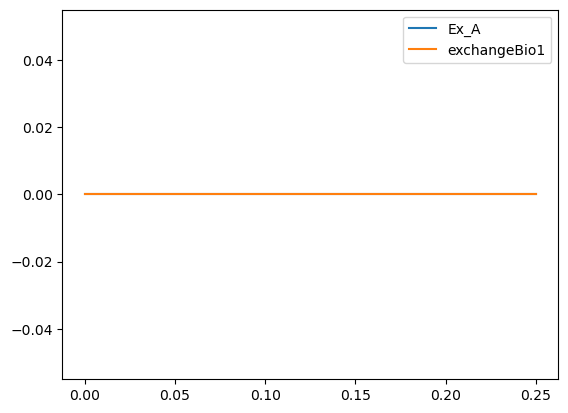

In [99]:
for met in x_df.columns:
    plt.plot(x_df.index, x_df[met], label=met)

plt.legend()

# add alpha = 1

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gifba
from IPython.display import clear_output


V = 1
gt = 1

vmax = 10
km=0.1
x0 = {"Ex_A": 0}
    #   "Ex_B": 10}
dt=0.01
alpha= 1

iters = 25
models, media = gifba.utils.load_simple_models("1a")
community = gifba.gifbaObject(models, media, "equal")
_, _ = community.run_gifba(iters=1, method="pfba", early_stop=True, v=False)
clear_output()

#time
t = np.arange(0, iters)

# concentrations
x = np.zeros((iters, len(community.org_exs)))
x_df = pd.DataFrame(x, 
                    columns=community.org_exs, 
                    index=t)
for met, conc in x0.items():
    x_df.loc[0, met] = conc

# fluxes
fluxes = np.zeros((iters * community.size, len(community.org_rxns)))
its_col = np.repeat(t, community.size)
mdl_idx_col = np.tile(range(community.size), iters)
fluxes_df = pd.DataFrame(fluxes, columns=community.org_rxns,
                         index=[its_col, mdl_idx_col])
fluxes_df.index.names = ["Iters", "Model"]


# media 
M = pd.Series(np.zeros(len(community.org_exs)), index=community.org_exs)
for met, flux in media.items():
    M[met] = np.abs(flux)
M["Ex_A"] = 5

for it in range(iters):
    print(f"Iteration {it}:")
    for mdl_idx in range(community.size):
        print(f"  Model {mdl_idx}:")
        # reset bounds
        for ex in community.models[mdl_idx].exchanges:
            community.models[mdl_idx].exchanges.get_by_id(ex.id).lower_bound = 0
            community.models[mdl_idx].exchanges.get_by_id(ex.id).upper_bound = 1000

            # find v bounds with michaelis menten
            conc = x_df.loc[it, ex.id]
            print(ex.id, ":  vmax", vmax, "conc", conc, "km", km)
            v_lb = vmax * conc / (km+conc)
            print(v_lb)
            community.models[mdl_idx].exchanges.get_by_id(ex.id).lower_bound = -v_lb

        # optimize
        sol = community.models[mdl_idx].optimize()

        print(f"    Objective Value: {sol.objective_value}")
        # store fluxes
        if sol.status == "optimal":
            fluxes_df.loc[(it, mdl_idx), list(sol.fluxes.index)] = sol.fluxes.values

    # update concentrations
    for met, x in x_df.loc[it].items():
        # print(met)
        # calc dx for exchanges
        # dx = dt*(M * alpha + gt*(E@rel_abund) * (1-alpha))
        exs = fluxes_df.loc[(it, slice(None)), met].to_numpy() @ community.rel_abund.flatten() #sum  exchange per org * rel_abund
        dx = dt * (M[met] * alpha + (1-alpha)*gt*exs)
        # dx = dt * (M[met]  + gt*exs)
        print(met, dx, x+dx)

        # update x_(t+1) based on x(t+1) = x(t) + dx
        x_df.loc[it+1, met] = x + dx
    print()

x_df.index = x_df.index * dt

        
            


Iteration 0:
  Model 0:
Ex_A :  vmax 10 conc 0.0 km 0.1
0.0
exchangeBio1 :  vmax 10 conc 0.0 km 0.1
0.0
    Objective Value: 0.0
Ex_A 0.05 0.05
exchangeBio1 0.0 0.0

Iteration 1:
  Model 0:
Ex_A :  vmax 10 conc 0.05 km 0.1
3.333333333333333
exchangeBio1 :  vmax 10 conc 0.0 km 0.1
0.0
    Objective Value: 3.333333333333333
Ex_A 0.05 0.1
exchangeBio1 0.0 0.0

Iteration 2:
  Model 0:
Ex_A :  vmax 10 conc 0.1 km 0.1
5.0
exchangeBio1 :  vmax 10 conc 0.0 km 0.1
0.0
    Objective Value: 5.0
Ex_A 0.05 0.15000000000000002
exchangeBio1 0.0 0.0

Iteration 3:
  Model 0:
Ex_A :  vmax 10 conc 0.15000000000000002 km 0.1
6.000000000000001
exchangeBio1 :  vmax 10 conc 0.0 km 0.1
0.0
    Objective Value: 6.000000000000001
Ex_A 0.05 0.2
exchangeBio1 0.0 0.0

Iteration 4:
  Model 0:
Ex_A :  vmax 10 conc 0.2 km 0.1
6.666666666666666
exchangeBio1 :  vmax 10 conc 0.0 km 0.1
0.0
    Objective Value: 6.666666666666666
Ex_A 0.05 0.25
exchangeBio1 0.0 0.0

Iteration 5:
  Model 0:
Ex_A :  vmax 10 conc 0.25 km 0.1

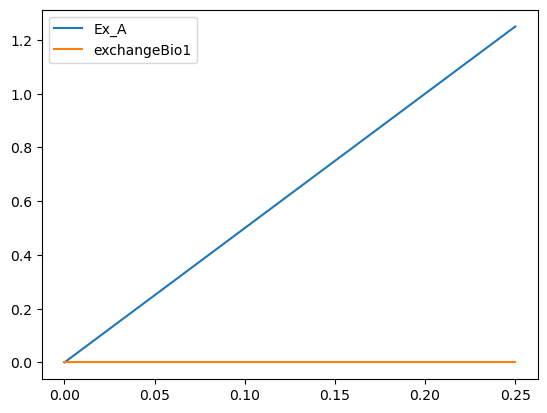

In [102]:
for met in x_df.columns:
    plt.plot(x_df.index, x_df[met], label=met)

plt.legend()

# add alpha = 0.5

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gifba
from IPython.display import clear_output


V = 1
gt = 1

vmax = 10
km=0.1
x0 = {"Ex_A": 10}
    #   "Ex_B": 10}
dt=0.01
alpha= 0.5

iters = 1000
models, media = gifba.utils.load_simple_models("1a")
community = gifba.gifbaObject(models, media, "equal")
_, _ = community.run_gifba(iters=1, method="pfba", early_stop=True, v=False)
clear_output()

#time
t = np.arange(0, iters)

# concentrations
x = np.zeros((iters, len(community.org_exs)))
x_df = pd.DataFrame(x, 
                    columns=community.org_exs, 
                    index=t)
for met, conc in x0.items():
    x_df.loc[0, met] = conc

# fluxes
fluxes = np.zeros((iters * community.size, len(community.org_rxns)))
its_col = np.repeat(t, community.size)
mdl_idx_col = np.tile(range(community.size), iters)
fluxes_df = pd.DataFrame(fluxes, columns=community.org_rxns,
                         index=[its_col, mdl_idx_col])
fluxes_df.index.names = ["Iters", "Model"]


# media 
M = pd.Series(np.zeros(len(community.org_exs)), index=community.org_exs)
for met, flux in media.items():
    M[met] = np.abs(flux)
M["Ex_A"] = 5

for it in range(iters):
    print(f"Iteration {it}:")
    for mdl_idx in range(community.size):
        print(f"  Model {mdl_idx}:")
        # reset bounds
        for ex in community.models[mdl_idx].exchanges:
            community.models[mdl_idx].exchanges.get_by_id(ex.id).lower_bound = 0
            community.models[mdl_idx].exchanges.get_by_id(ex.id).upper_bound = 1000

            # find v bounds with michaelis menten
            conc = x_df.loc[it, ex.id]
            print(ex.id, ":  vmax", vmax, "conc", conc, "km", km)
            v_lb = vmax * conc / (km+conc)
            print(v_lb)
            community.models[mdl_idx].exchanges.get_by_id(ex.id).lower_bound = -v_lb

        # optimize
        sol = community.models[mdl_idx].optimize()

        print(f"    Objective Value: {sol.objective_value}")
        # store fluxes
        if sol.status == "optimal":
            fluxes_df.loc[(it, mdl_idx), list(sol.fluxes.index)] = sol.fluxes.values

    # update concentrations
    for met, x in x_df.loc[it].items():
        # print(met)
        # calc dx for exchanges
        # dx = dt*(M * alpha + gt*(E@rel_abund) * (1-alpha))
        exs = fluxes_df.loc[(it, slice(None)), met].to_numpy() @ community.rel_abund.flatten() #sum  exchange per org * rel_abund
        dx = dt * (M[met] * alpha + (1-alpha)*gt*exs)
        # dx = dt * (M[met]  + gt*exs)
        print(met, dx, x+dx)

        # update x_(t+1) based on x(t+1) = x(t) + dx
        x_df.loc[it+1, met] = x + dx
    print()

x_df.index = x_df.index * dt

        
            


Iteration 0:
  Model 0:
Ex_A :  vmax 10 conc 10.0 km 0.1
9.900990099009901
exchangeBio1 :  vmax 10 conc 0.0 km 0.1
0.0
    Objective Value: 9.900990099009901
exchangeBio1 0.04950495049504951 0.04950495049504951
Ex_A -0.024504950495049506 9.97549504950495

Iteration 1:
  Model 0:
Ex_A :  vmax 10 conc 9.97549504950495 km 0.1
9.900749293698563
exchangeBio1 :  vmax 10 conc 0.04950495049504951 km 0.1
3.311258278145695
    Objective Value: 9.900749293698563
exchangeBio1 0.049503746468492815 0.09900869696354232
Ex_A -0.024503746468492817 9.950991303036457

Iteration 2:
  Model 0:
Ex_A :  vmax 10 conc 9.950991303036457 km 0.1
9.900507326108432
exchangeBio1 :  vmax 10 conc 0.09900869696354232 km 0.1
4.9750939770074645
    Objective Value: 9.900507326108432
exchangeBio1 0.04950253663054216 0.14851123359408447
Ex_A -0.024502536630542162 9.926488766405914

Iteration 3:
  Model 0:
Ex_A :  vmax 10 conc 9.926488766405914 km 0.1
9.900264187863
exchangeBio1 :  vmax 10 conc 0.14851123359408447 km 0.1
5.

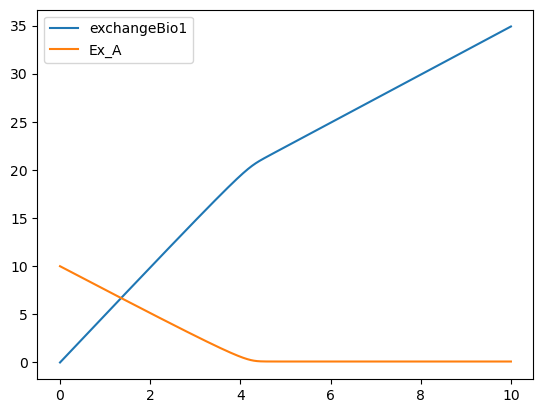

In [32]:
for met in x_df.columns:
    plt.plot(x_df.index, x_df[met], label=met)

plt.legend()

In [ ]:
fluxes_df.loc[(slice(600, None), 0), "exchangeBio1"].sum() / (400* alpha)
fluxes_df.iloc[-1]["exchangeBio1"] / alpha

19.809304098933126